In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

---
## Загрузка изображения

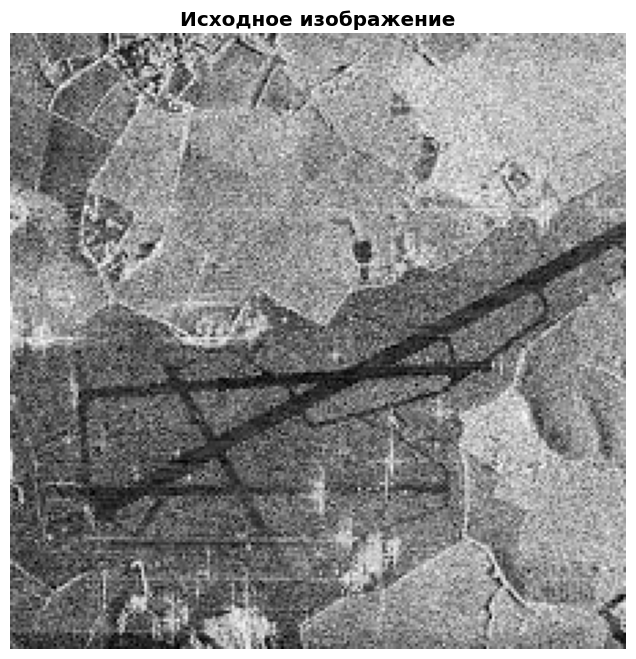

In [ ]:
image = cv2.imread('sar_3.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 8))
plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение', fontweight='bold')
plt.axis('off')
plt.show()

---
## Исследование методов бинаризации

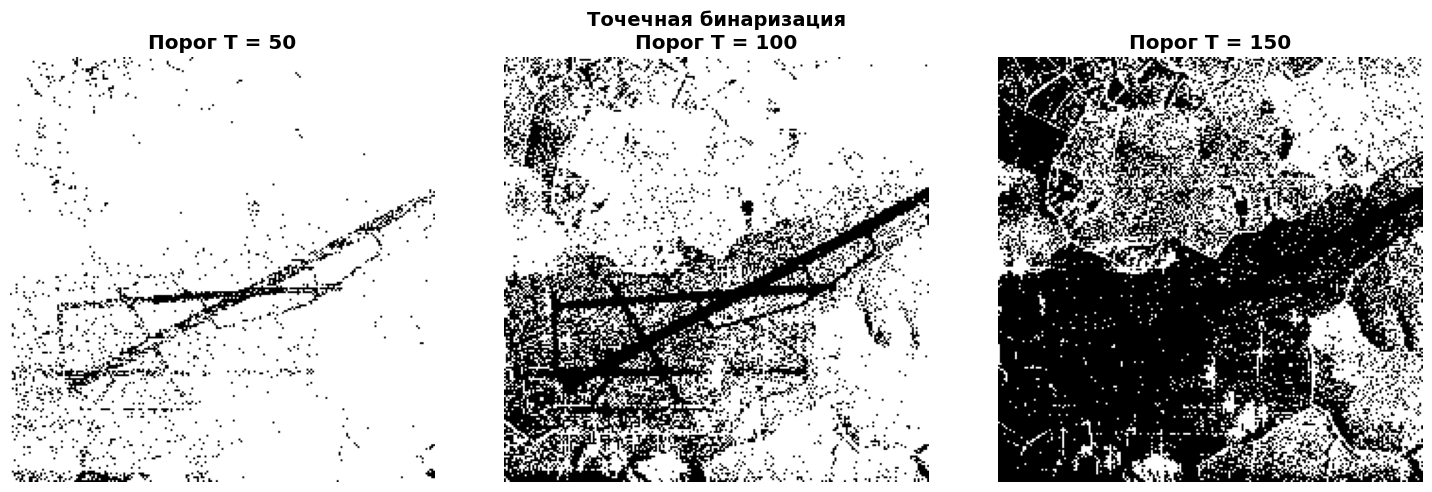

In [ ]:
# Сравнение разных методов бинаризации
thresholds = [50, 100, 150]

# Точечная бинаризация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, T in enumerate(thresholds):
    bin_img = np.where(image_gray >= T, 255, 0).astype(np.uint8)
    axes[idx].imshow(bin_img, cmap='gray')
    axes[idx].set_title(f'Порог T = {T}', fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Точечная бинаризация', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

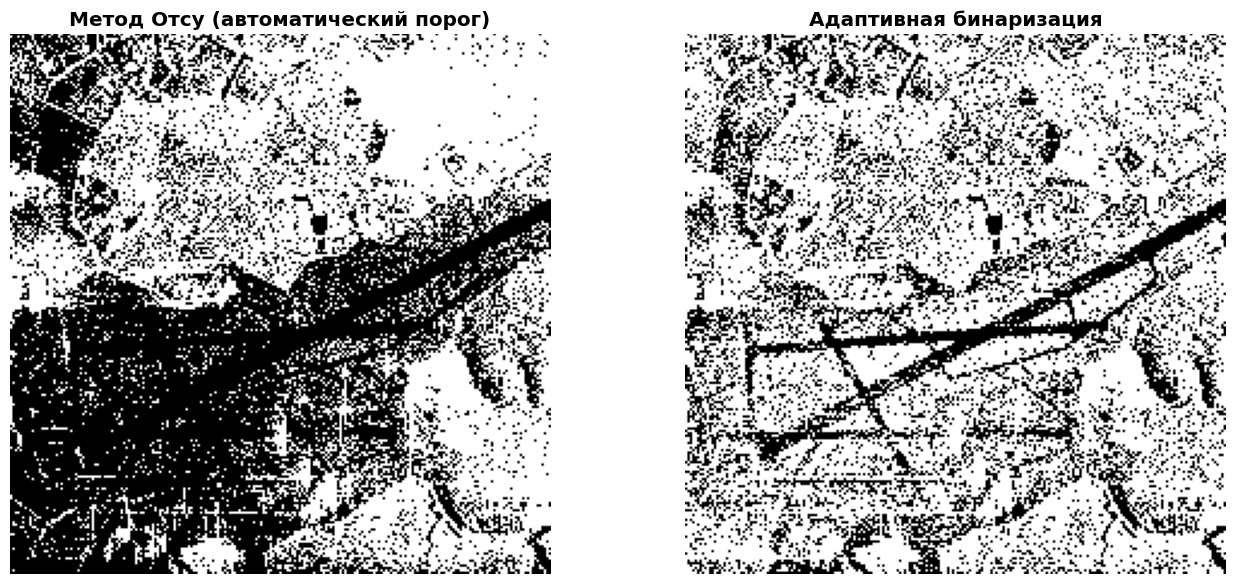

In [ ]:
# Автоматические методы
_, otsu = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adaptive = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 71, 21)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(otsu, cmap='gray')
axes[0].set_title('Метод Отсу (автоматический порог)', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(adaptive, cmap='gray')
axes[1].set_title('Адаптивная бинаризация', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

---
## Детектирование границ

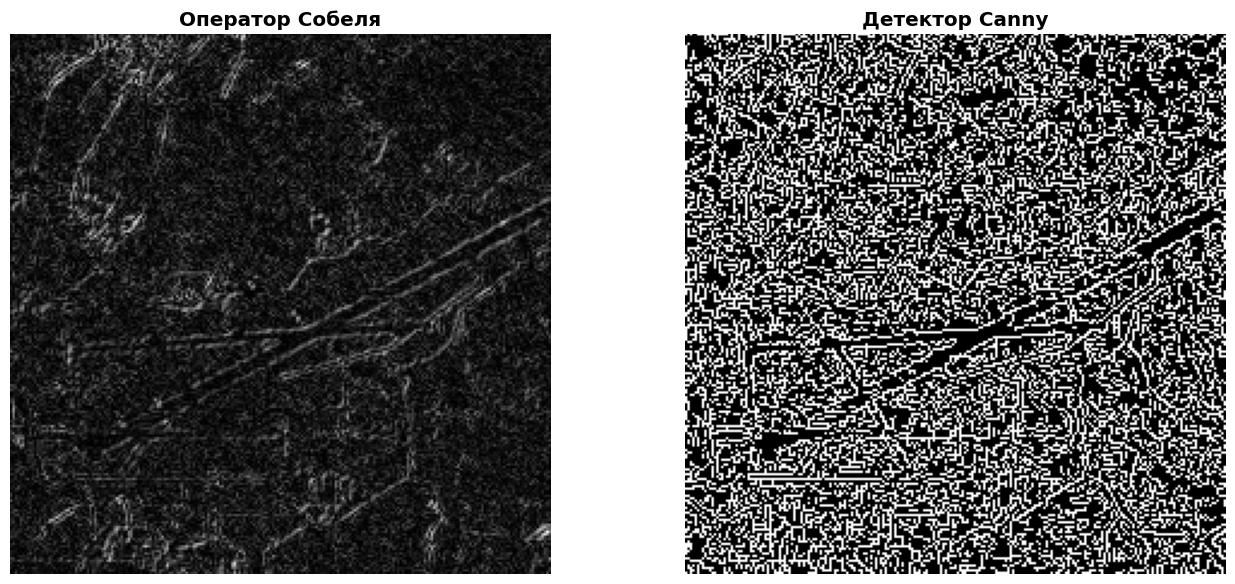

In [ ]:
# Оператор Собеля
sobel_x = cv2.Sobel(image_gray, cv2.CV_16S, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image_gray, cv2.CV_16S, 0, 1, ksize=3)
sobel_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

# Детектор Canny
canny = cv2.Canny(image_gray, 100, 200)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(np.abs(sobel_combined), cmap='gray')
axes[0].set_title('Оператор Собеля', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(canny, cmap='gray')
axes[1].set_title('Детектор Canny', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

---
## Преобразование Хафа — поиск линий

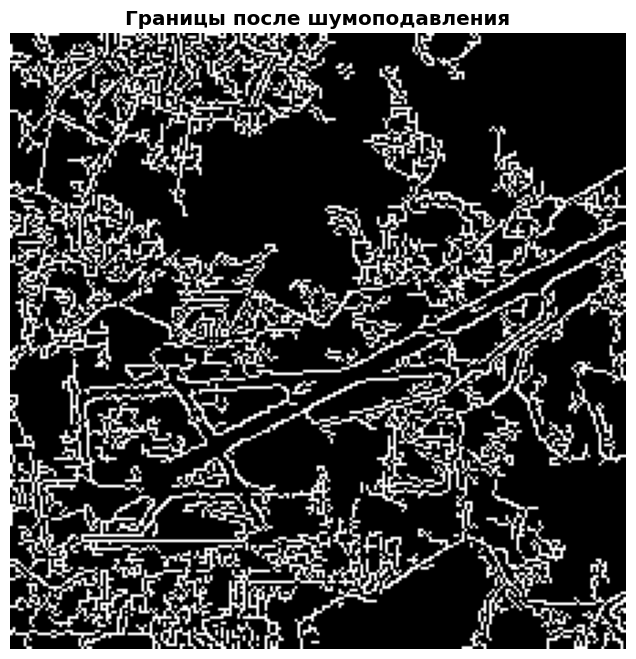

In [ ]:
# Предобработка для улучшения результата
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
gray_clean = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
denoised = cv2.fastNlMeansDenoising(gray_clean, h=20)

# Canny на очищенном изображении
edges = cv2.Canny(denoised, 0, 250, apertureSize=3)

plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.title('Границы после шумоподавления', fontweight='bold')
plt.axis('off')
plt.show()

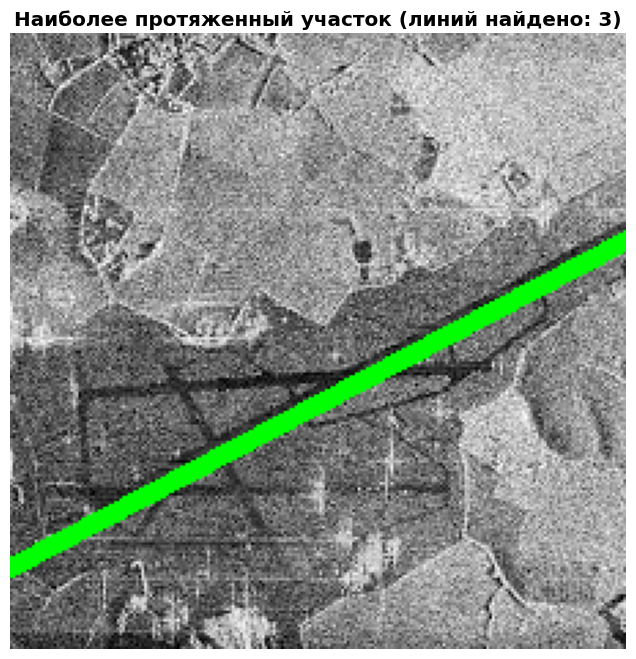

In [ ]:
# Преобразование Хафа
lines = cv2.HoughLines(edges, 1, np.pi / 180, 110)

result_img = image_bgr.copy()
max_len = 0
best_line = None

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        
        pt1 = (int(x0 - 1000 * b), int(y0 + 1000 * a))
        pt2 = (int(x0 + 1000 * b), int(y0 - 1000 * a))
        
        length = np.hypot(pt2[0] - pt1[0], pt2[1] - pt1[1])
        if length > max_len:
            max_len = length
            best_line = (pt1, pt2)

if best_line:
    cv2.line(result_img, best_line[0], best_line[1], (0, 255, 0), 5)

plt.figure(figsize=(10, 8))
plt.imshow(result_img)
plt.title(f'Наиболее протяженный участок (линий найдено: {len(lines) if lines is not None else 0})', fontweight='bold')
plt.axis('off')
plt.show()

---
## Выделение дорожной полосы

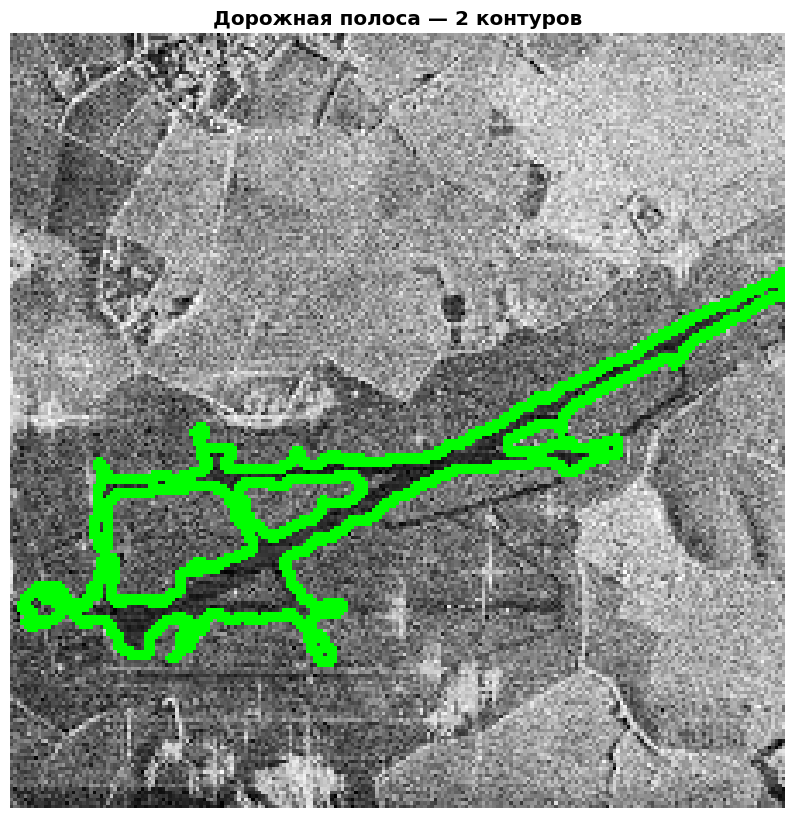

In [ ]:
# Фильтрация + бинаризация
smoothed = cv2.medianBlur(gray_clean, 5)
_, binary = cv2.threshold(smoothed, 80, 255, cv2.THRESH_BINARY_INV)

# Поиск и фильтрация контуров
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
large_contours = [c for c in contours if cv2.contourArea(c) > 350]

contour_img = image_bgr.copy()
cv2.drawContours(contour_img, large_contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title(f'Дорожная полоса — {len(large_contours)} контуров', fontweight='bold')
plt.axis('off')
plt.show()